In [1]:
import glob
import os
import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy.fftpack import fft
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import scipy

# Wavelet library
import pywt

# Magic function
%matplotlib inline

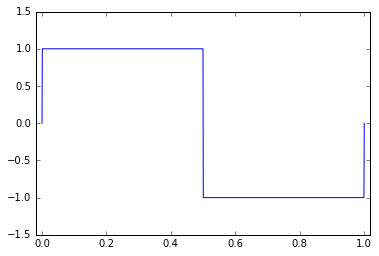

In [2]:
w = pywt.Wavelet('Haar')
phi, psi, x = w.wavefun(level=10)

fig, ax = plt.subplots()
ax.set_xlim(-.02,1.02)
ax.plot(x, psi);

In [5]:
def doppler(x):
    """
    Parameters
    ----------
    x : array-like
        Domain of x is in (0,1]
 
    """
    if not np.all((x >= 0) & (x <= 1)):
        raise ValueError("Domain of doppler is x in (0,1]")
    return np.sqrt(x*(1-x))*np.sin((2.1*np.pi)/(x+.05))
 
def blocks(x):
    """
    Piecewise constant function with jumps at t.
 
    Constant scaler is not present in Donoho and Johnstone.
    """
    K = lambda x : (1 + np.sign(x))/2.
    t = np.array([[.1, .13, .15, .23, .25, .4, .44, .65, .76, .78, .81]]).T
    h = np.array([[4, -5, 3, -4, 5, -4.2, 2.1, 4.3, -3.1, 2.1, -4.2]]).T
    return 3.655606 * np.sum(h*K(x-t), axis=0)
 
def bumps(x):
    """
    A sum of bumps with locations t at the same places as jumps in blocks.
    The heights h and widths s vary and the individual bumps are of the
    form K(t) = 1/(1+|x|)**4
    """
    K = lambda x : (1. + np.abs(x)) ** -4.
    t = np.array([[.1, .13, .15, .23, .25, .4, .44, .65, .76, .78, .81]]).T
    h = np.array([[4, 5, 3, 4, 5, 4.2, 2.1, 4.3, 3.1, 2.1, 4.2]]).T
    w = np.array([[.005, .005, .006, .01, .01, .03, .01, .01, .005, .008, .005]]).T
    return np.sum(h*K((x-t)/w), axis=0)
 
def heavisine(x):
    """
    Sinusoid of period 1 with two jumps at t = .3 and .72
    """
    return 4 * np.sin(4*np.pi*x) - np.sign(x - .3) - np.sign(.72 - x)

In [6]:
x = np.linspace(0, 1, 2**11)
dop = doppler(x)
blk = blocks(x)
bmp = bumps(x)
hsin = heavisine(x)

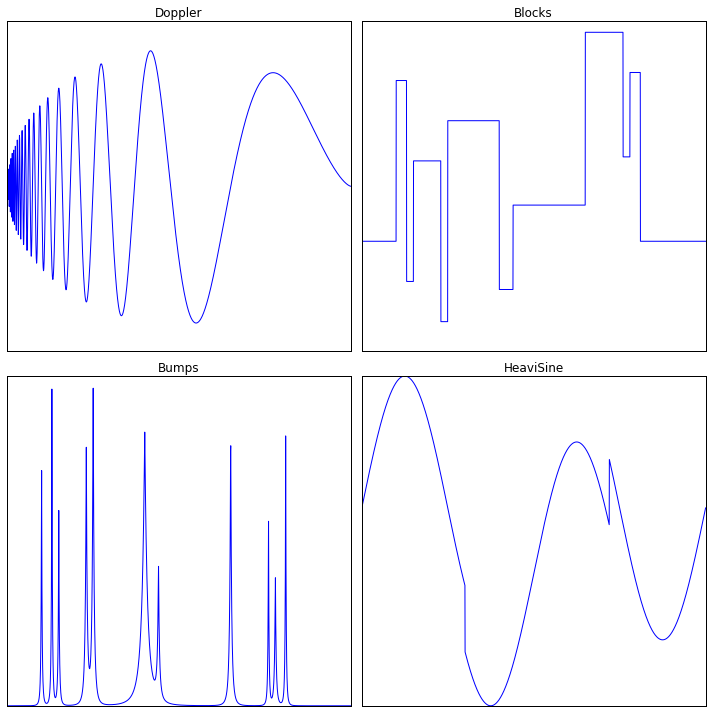

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))
ax1 = axes[0,0]
ax2 = axes[0,1]
ax3 = axes[1,0]
ax4 = axes[1,1]

ax1.plot(x,dop)
ax1.set_title("Doppler")

ax2.plot(x,blk)
ax2.set_title("Blocks")

ax3.plot(x,bmp)
ax3.set_title("Bumps")

ax4.set_title("HeaviSine")
ax4.plot(x,hsin)

for ax in fig.axes:
    ax.tick_params(labelbottom=False, labelleft=False, bottom=False, 
                   top=False, left=False, right=False)

fig.tight_layout();

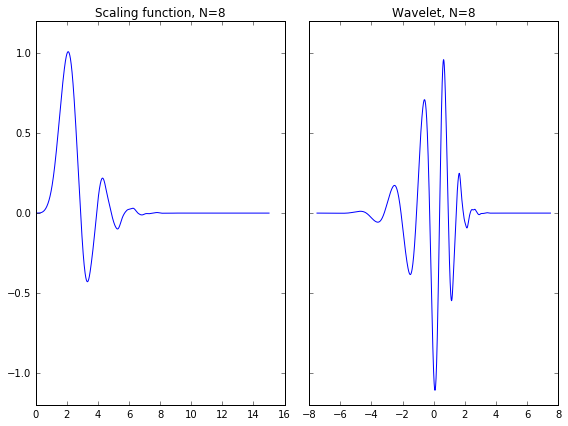

In [11]:
db8 = pywt.Wavelet('db8')
scaling, wavelet, x = db8.wavefun()

fig, axes = plt.subplots(1, 2, sharey=True, figsize=(8,6))
ax1, ax2 = axes

ax1.plot(x, scaling);
ax1.set_title('Scaling function, N=8');
ax1.set_ylim(-1.2, 1.2);

ax2.set_title('Wavelet, N=8');
ax2.tick_params(labelleft=False);
ax2.plot(x-x.mean(), wavelet);

fig.tight_layout()

In [12]:
def coef_pyramid_plot(coefs, first=0, scale='uniform', ax=None):
    """
    Parameters
    ----------
    coefs : array-like
        Wavelet Coefficients. Expects an iterable in order Cdn, Cdn-1, ...,
        Cd1, Cd0.
    first : int, optional
        The first level to plot.
    scale : str {'uniform', 'level'}, optional
        Scale the coefficients using the same scale or independently by
        level.
    ax : Axes, optional
        Matplotlib Axes instance

    Returns
    -------
    Figure : Matplotlib figure instance
        Either the parent figure of `ax` or a new pyplot.Figure instance if
        `ax` is None.
    """

    if ax is None:
        import matplotlib.pyplot as plt
        fig = plt.figure()
        ax = fig.add_subplot(111, axisbg='lightgrey')
    else:
        fig = ax.figure

    n_levels = len(coefs)
    n = 2**(n_levels - 1) # assumes periodic

    if scale == 'uniform':
        biggest = [np.max(np.abs(np.hstack(coefs)))] * n_levels
    else:
        # multiply by 2 so the highest bars only take up .5
        biggest = [np.max(np.abs(i))*2 for i in coefs]

    for i in range(first,n_levels):
        x = np.linspace(2**(n_levels - 2 - i), n - 2**(n_levels - 2 - i), 2**i)
        ymin = n_levels - i - 1 + first
        yheight = coefs[i]/biggest[i]
        ymax = yheight + ymin
        ax.vlines(x, ymin, ymax, linewidth=1.1)

    ax.set_xlim(0,n)
    ax.set_ylim(first - 1, n_levels)
    ax.yaxis.set_ticks(np.arange(n_levels-1,first-1,-1))
    ax.yaxis.set_ticklabels(np.arange(first,n_levels))
    ax.tick_params(top=False, right=False, direction='out', pad=6)
    ax.set_ylabel("Levels", fontsize=14)
    ax.grid(True, alpha=.85, color='white', axis='y', linestyle='-')
    ax.set_title('Wavelet Detail Coefficients', fontsize=16,
            position=(.5,1.05))
    fig.subplots_adjust(top=.89)

    return fig

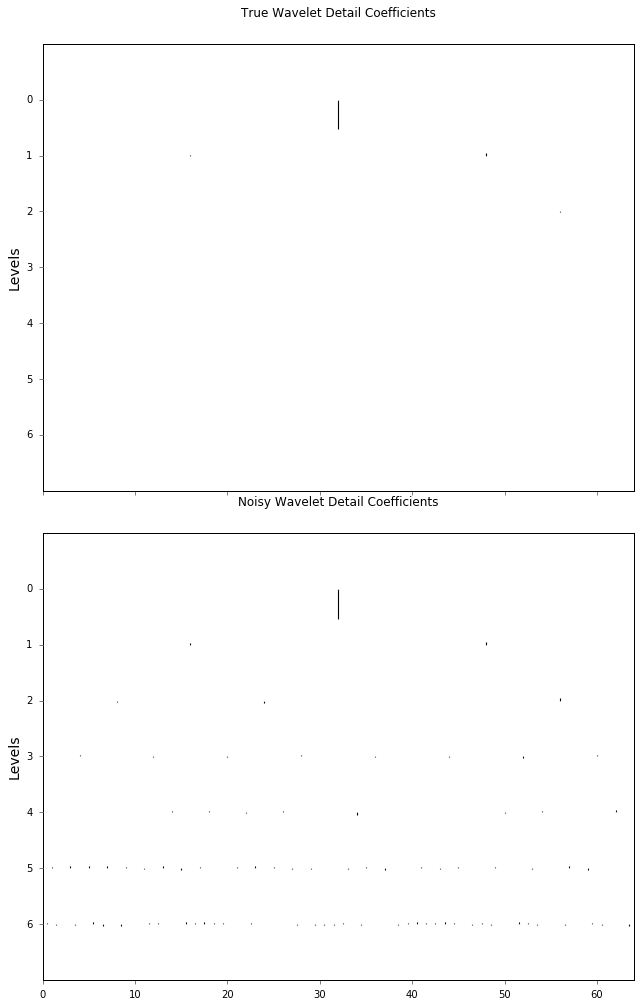

In [34]:
from scipy import stats
import numpy as np

np.random.seed(12345)
blck = blocks(np.linspace(0,1,2**11))
nblck = blck + stats.norm().rvs(2**11)

true_coefs = pywt.wavedec(blck, 'db8', level=7, mode='per')
noisy_coefs = pywt.wavedec(nblck, 'db8', level=7, mode='per')

fig, axes = plt.subplots(2, 1, figsize=(9,14), sharex=True)

fig = coef_pyramid_plot(true_coefs[1:], ax=axes[0]) # omit smoothing coefs
axes[0].set_title("True Wavelet Detail Coefficients");

fig = coef_pyramid_plot(noisy_coefs[1:], ax=axes[1]) ;
axes[1].set_title("Noisy Wavelet Detail Coefficients");

fig.tight_layout()

In [42]:
from statsmodels.robust import mad

sigma = mad(noisy_coefs[-1])
uthresh = sigma*np.sqrt(2*np.log(len(nblck)))

denoised = noisy_coefs[:]

denoised[1:] = (pywt.threshold(i, value=uthresh, mode="soft") for i in denoised[1:])

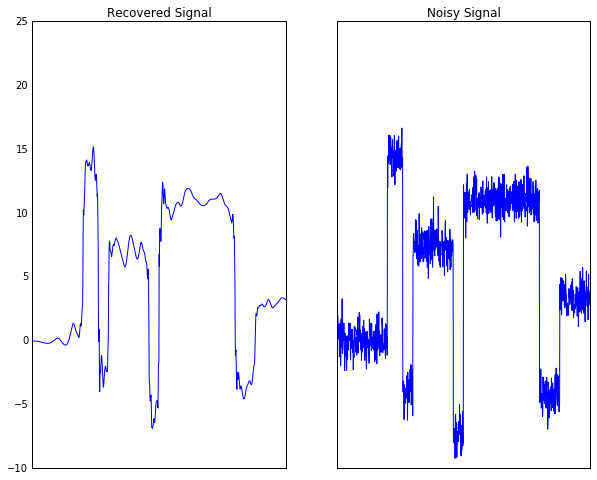

In [43]:
signal = pywt.waverec(denoised, 'db8', mode='per')

fig, axes = plt.subplots(1, 2, sharey=True, sharex=True,
                         figsize=(10,8))
ax1, ax2 = axes

ax1.plot(signal)
ax1.set_xlim(0,2**10)
ax1.set_title("Recovered Signal")
ax1.margins(.1)

ax2.plot(nblck)
ax2.set_title("Noisy Signal")

for ax in fig.axes:
    ax.tick_params(labelbottom=False, top=False, bottom=False, left=False, 
                 right=False)

In [38]:
dir(pywt)

['BaseNode',
 'MODES',
 'Modes',
 'Node',
 'Node2D',
 'Tester',
 'Wavelet',
 'WaveletPacket',
 'WaveletPacket2D',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 '_functions',
 '_multidim',
 '_multilevel',
 '_pywt',
 '_thresholding',
 '_wavelet_packets',
 'absolute_import',
 'central_frequency',
 'centrfrq',
 'data',
 'division',
 'downcoef',
 'dwt',
 'dwt2',
 'dwt_coeff_len',
 'dwt_max_level',
 'dwtn',
 'families',
 'idwt',
 'idwt2',
 'idwtn',
 'integrate_wavelet',
 'intwave',
 'iswt',
 'iswt2',
 'orthfilt',
 'orthogonal_filter_bank',
 'print_function',
 'qmf',
 'scal2frq',
 'scale2frequency',
 'swt',
 'swt2',
 'swt_max_level',
 'test',
 'threshold',
 'upcoef',
 'version',
 'wavedec',
 'wavedec2',
 'wavedecn',
 'wavelist',
 'waverec',
 'waverec2',
 'waverecn']

In [2]:
files = sorted(glob.glob("./train_1/*.mat"))

In [62]:
def mat_to_pd(path):
    mat = loadmat(path)
    names = mat['dataStruct'].dtype.names
    ndata = {n: mat['dataStruct'][n][0, 0] for n in names}
    return pd.DataFrame(ndata['data'], columns=ndata['channelIndices'][0])

def get_fft_bins_edges(pd):
    bins  = []
    edges = []
    for i in range(1, 17):
        freq = np.abs(np.fft.fft(pd[float(str(i) + ".0")]))
        h = np.histogram(np.log(freq).ravel(), bins=100)
        bins.append(h[0])
        edges.append(h[1])
    return np.array(bins), np.array(edges)

def get_fft_bins(pd):
    return get_fft_bins_edges(pd)[0]
    
def get_fft_edges(pd):
    return get_fft_bins_edges(pd)[1]

In [73]:
z = np.zeros((10, 10))
x = np.ones((10, 10))
np.savez_compressed(file="./fuck", fff=z, uuu=x)
d = np.load("./fuck.npz")
print(d.keys())

['uuu', 'fff']


In [76]:
def save_npz(column_number, transform_method=lambda x: x):
    file_list = sorted(glob.glob("./train_*/*.mat"))
    X, y = [], []
    for file in file_list:
        filename = os.path.basename(file)[:-4].split("_")
        try:    
            data = mat_to_pd(file)
            X.append(transform_method(data))
            y.append(filename[2])
        except Exception as e:
            print("error " + str(e))
            continue
            
    np.savez_compressed(file="./train.npz", X=np.array(X), y=np.array(y))

In [84]:
np.savez_compressed(file="./train.npz", X=np.array(X), y=np.array(y))

In [86]:
!ls -lh | grep train.npz 

-rw-r--r--     1 lemhell  staff   3,3M  9 сен 22:36 train.npz


In [88]:
pca = PCA()
pca.fit(X)

PCA(copy=True, n_components=None, whiten=False)

In [102]:
X_transformed[np.where(y == 0)[0]]

array([[ -1.30708290e+04,  -1.54267114e+04,   1.13589474e+04, ...,
         -2.63015904e-01,  -7.65135868e-02,   1.99662509e-12],
       [ -1.12875820e+04,  -1.36667440e+04,   7.52046394e+03, ...,
         -4.28761389e-04,   1.55556006e+00,   5.09601250e-11],
       [ -3.94061677e+03,  -9.69654484e+03,  -3.38517428e+04, ...,
          2.86872454e-01,   3.11992675e-01,  -5.83284532e-11],
       ..., 
       [  9.34888357e+03,  -2.80634630e+04,  -6.72121269e+03, ...,
         -8.81180062e-01,  -2.13781711e-01,  -1.18678400e-11],
       [ -7.38621272e+03,  -5.98117330e+03,   1.92282221e+04, ...,
         -5.28199220e-01,  -7.01961798e-01,  -6.63646915e-12],
       [  1.74160217e+04,  -2.53564647e+04,   3.60807261e+03, ...,
          1.63483887e-02,   1.04507820e+00,   1.24344979e-11]])

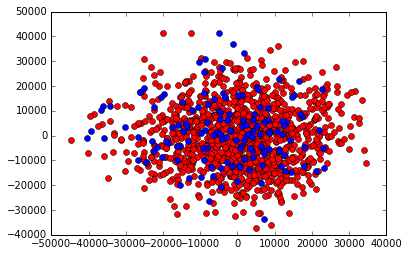

In [108]:
X_transformed = pca.transform(X)

plt.plot(X_transformed[np.where(y == 0)[0], 4], X_transformed[np.where(y == 0)[0], 5], 'ro')
plt.plot(X_transformed[np.where(y == 1)[0], 4], X_transformed[np.where(y == 1)[0], 5], 'bo')

In [77]:
save_npz(100, get_fft_bins)

error range parameter must be finite.
error range parameter must be finite.
error range parameter must be finite.
error range parameter must be finite.
error range parameter must be finite.
error range parameter must be finite.
error range parameter must be finite.
error range parameter must be finite.
error range parameter must be finite.
error range parameter must be finite.
error range parameter must be finite.
error range parameter must be finite.
error range parameter must be finite.
error range parameter must be finite.
error Did not fully consume compressed contents of an miCOMPRESSED element. This can indicate that the .mat file is corrupted.
error range parameter must be finite.
error range parameter must be finite.
error range parameter must be finite.
error range parameter must be finite.
error range parameter must be finite.
error range parameter must be finite.
error range parameter must be finite.
error range parameter must be finite.
error range parameter must be finite.

TypeError: savez_compressed() missing 1 required positional argument: 'file'

In [4]:
# transform_method is applied to data from .mat
# elem - element from tuple, returned after transform_method
def create_csv(data, transform_method=None, elem=None, elem_length=None):
    file_list = sorted(glob.glob("./train_*/*.mat"))
    out = open("./train.csv", "w")
    out.write("id,pid")
    if data is not None:
        data_range = len(data)
    if elem is not None:
        data_range = elem_length*16
    for i in range(data_range):
        out.write(",d" + str(i))
    out.write(",result\n")
    for file in file_list:
        filename = os.path.basename(file)[:-4].split("_")
        patient_id = filename[0]
        id = 100000*patient_id + filename[1]
        result = filename[2]
        try:
        
            data = mat_to_pd(file)
            if transform_method is not None:
                data = transform_method(data)[elem]
        except Exception as e:
            print("error " + str(e))
            continue
        out.write(str(id))
        out.write("," + str(patient_id))
        for datum in data:
            for element in datum:
                out.write("," + str(element))
        out.write("," + str(result))
        out.write("\n")
    out.close
        

In [34]:
def test_peaks_ttest():
    from scipy.stats import ttest_ind
    seiz_peaks_length = []
    no_seiz_peaks_length = []
    for file in files:
        try:
            ser = pd.Series(mat_to_pd(file).as_matrix().ravel())
        except:
            continue
        if int(os.path.basename(file)[:-4].split("_")[2]) == 1:
            seiz_peaks_length.append(len(ser[np.abs(ser) > 1000]))
        else:
            no_seiz_peaks_length.append(len(ser[np.abs(ser) > 1000]))
    print(ttest_ind(seiz_peaks_length, no_seiz_peaks_length, equal_var=False))
    print(np.std(seiz_peaks_length), np.std(no_seiz_peaks_length), np.mean(seiz_peaks_length), np.mean(no_seiz_peaks_length))

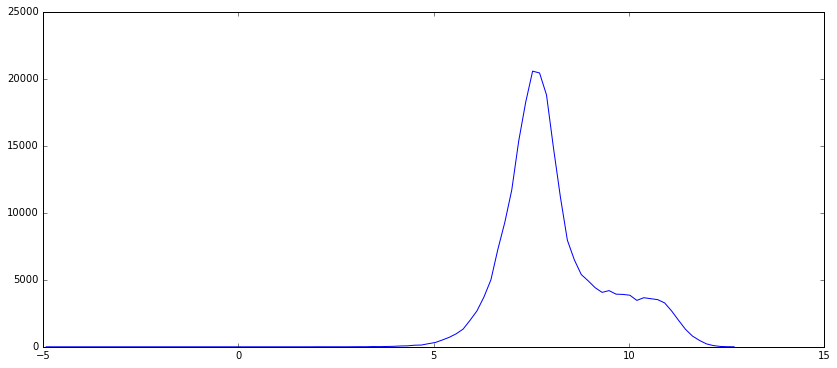

In [65]:
test = mat_to_pd("./train_1/1_1_1.mat")

# pd.Series(fft(test[1.0]))[:100].plot()
freq = np.abs(np.fft.fft(test[1.0]))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 6))
h = np.histogram(np.log(freq).ravel(), bins=100)
plt.plot(h[1][1:], h[0])

In [72]:
len(get_fft_bins_edges(test)[0][1])

100

In [5]:
create_csv(None, get_fft_bins_edges, 0, 100)

error range parameter must be finite.
error range parameter must be finite.
error range parameter must be finite.
error range parameter must be finite.
error range parameter must be finite.
error range parameter must be finite.
error range parameter must be finite.
error range parameter must be finite.
error range parameter must be finite.
error range parameter must be finite.
error range parameter must be finite.
error range parameter must be finite.
error range parameter must be finite.
error range parameter must be finite.
error Did not fully consume compressed contents of an miCOMPRESSED element. This can indicate that the .mat file is corrupted.
error range parameter must be finite.
error range parameter must be finite.
error range parameter must be finite.
error range parameter must be finite.
error range parameter must be finite.
error range parameter must be finite.
error range parameter must be finite.
error range parameter must be finite.
error range parameter must be finite.

In [6]:
print(1)

1


In [9]:
data = pd.read_csv("./train.csv")
del(data['id'])
data.head()

,pid,d0,d1,d2,d3,d4,d5,d6,d7,d8,...,d1591,d1592,d1593,d1594,d1595,d1596,d1597,d1598,d1599,result
0,1,1,0,0,0,0,0,0,0,0,...,466,378,260,184,88,46,24,8,4,0
1,1,1,0,0,0,0,0,0,0,0,...,294,168,132,86,46,24,14,2,6,0
2,1,1,0,0,0,0,0,0,0,0,...,290,238,178,138,80,74,44,20,20,0
3,1,1,0,0,0,0,0,0,0,0,...,284,228,190,128,82,38,22,8,2,0
4,1,1,0,0,0,0,0,0,0,0,...,344,284,216,160,110,56,32,22,8,0


In [10]:
data.describe()

,pid,d0,d1,d2,d3,d4,d5,d6,d7,d8,...,d1591,d1592,d1593,d1594,d1595,d1596,d1597,d1598,d1599,result
count,1265.0,1265.0,1265.0,1265.0,1265.0,1265.0,1265.0,1265.0,1265.000000,1265.000000,...,1265.000000,1265.000000,1265.000000,1265.000000,1265.000000,1265.000000,1265.000000,1265.000000,1265.000000,1265.000000
mean,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001581,0.001581,...,303.707510,243.617391,184.812648,132.463241,87.557312,52.727273,28.327273,14.474308,9.464032,0.110672
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.056232,0.056232,...,165.383118,142.711088,118.910363,99.689600,77.304224,64.923585,51.725576,46.369828,48.552078,0.313850
min,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000
25%,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,212.000000,154.000000,104.000000,64.000000,36.000000,18.000000,10.000000,4.000000,2.000000,0.000000
50%,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,314.000000,252.000000,190.000000,130.000000,82.000000,46.000000,22.000000,10.000000,6.000000,0.000000
75%,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,402.000000,330.000000,252.000000,184.000000,122.000000,74.000000,40.000000,18.000000,10.000000,0.000000
max,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.000000,2.000000,...,2060.000000,1422.000000,1186.000000,1442.000000,1534.000000,1766.000000,1616.000000,1306.000000,1264.000000,1.000000


In [17]:
X = data.drop(['result', 'pid'], axis=1)
y = data['result']

In [40]:
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier

# for train, test in KFold(50, 5):
#     X_train, X_test = X.ix[train, :], X.ix[test, :]
#     y_train, y_test = y[train], y[test]
#     clas = RandomForestClassifier(max_depth=4, n_estimators=1000)
#     clas.fit(X_train, y_train)
#     print(clas.score(X_test, y_test))

clas = RandomForestClassifier(max_depth=4, n_estimators=1000)
    
cross_val_score(clas, X, y, scoring="roc_auc", cv=5)

array([ 0.56079365,  0.47031746,  0.53634921,  0.50984127,  0.39047619])